In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_path(cart_path,target,xlim=[-5,5],ylim=[-5,5]):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


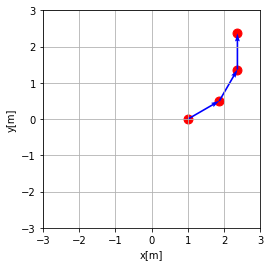

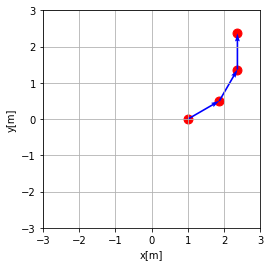

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes,[-3,3],[-3,3])

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_MAX_TRANS_VEL = 0.3 # [m/s]
DATA_MAX_ROTATE_VEL = 2*xp.pi # [rad/s]
DATA_M_PER_STEP = DATA_MAX_TRANS_VEL / DATA_HZ # [m/step]
DATA_RAD_PER_STEP = DATA_MAX_ROTATE_VEL / DATA_HZ # [rad/step]

print('DATA_SIZE          :',DATA_SIZE)
print('DATA_NUM_WAYPOINTS :',DATA_NUM_WAYPOINTS)
print('DATA_NUM_STEP      :',DATA_NUM_STEP)
print('DATA_HZ            :',DATA_HZ) 
print('DATA_MAX_TRANS_VEL :',DATA_MAX_TRANS_VEL)
print('DATA_MAX_ROTATE_VEL:',DATA_MAX_ROTATE_VEL)
print('DATA_M_PER_STEP    :',DATA_M_PER_STEP)
print('DATA_RAD_PER_STEP  :', DATA_RAD_PER_STEP)

X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP)
    d_rotate = data.rotate_path(d,rand_rad/2)
    #d_xy_fl = xp.ravel(d_xy[0:DATA_WAYPOINTS])
    X_train.append(d_rotate)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

DATA_SIZE          : 1000
DATA_NUM_WAYPOINTS : 10
DATA_NUM_STEP      : 10
DATA_HZ            : 10
DATA_MAX_TRANS_VEL : 0.3
DATA_MAX_ROTATE_VEL: 6.283185307179586
DATA_M_PER_STEP    : 0.03
DATA_RAD_PER_STEP  : 0.6283185307179586
1000
(10, 3)


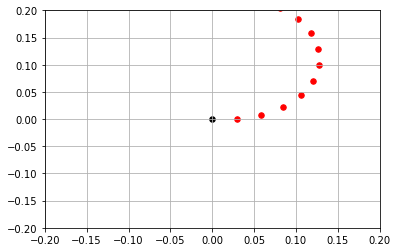

 -- x_train -- 
[[ 2.99122627e-02 -8.13111342e-08 -1.17321861e+00]
 [ 5.87799927e-02  7.83558245e-03 -9.08168608e-01]
 [ 8.45870332e-02  2.29597392e-02 -6.43118608e-01]
 [ 1.05530990e-01  4.43160998e-02 -3.78068608e-01]
 [ 1.20149112e-01  7.04131105e-02 -1.13018608e-01]
 [ 1.27420452e-01  9.94281251e-02  1.52031392e-01]
 [ 1.26837171e-01  1.29334700e-01  4.17081392e-01]
 [ 1.18440007e-01  1.58044125e-01  6.82131392e-01]
 [ 1.02815426e-01  1.83551300e-01  9.47181392e-01]
 [ 8.10546694e-02  2.04074772e-01  1.21223139e+00]]


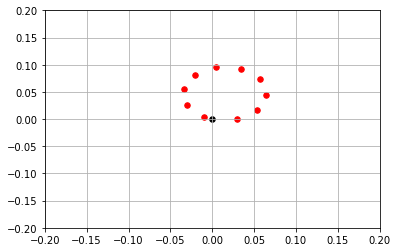

 -- x_train -- 
[[ 2.95409386e-02 -7.80003575e-08 -6.59678686e-01]
 [ 5.37979043e-02  1.68601316e-02 -5.22686864e-02]
 [ 6.40931614e-02  4.45490235e-02  5.55141314e-01]
 [ 5.67436639e-02  7.31611178e-02  1.16255131e+00]
 [ 3.43786358e-02  9.24606663e-02  1.76996131e+00]
 [ 4.99898725e-03  9.55434096e-02  2.37737131e+00]
 [-2.08849471e-02  8.13065211e-02  2.98478131e+00]
 [-3.40133965e-02  5.48431337e-02  3.59219131e+00]
 [-2.96897631e-02  2.56203131e-02  4.19960131e+00]
 [-9.46079211e-03  4.09228975e-03  4.80701131e+00]]


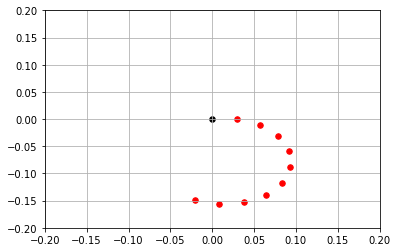

 -- x_train -- 
[[ 2.98198161e-02  7.72907777e-08 -2.14081392e+00]
 [ 5.75123427e-02 -1.10609080e-02 -2.52082392e+00]
 [ 7.91264616e-02 -3.16047951e-02 -2.90083392e+00]
 [ 9.15783103e-02 -5.87004201e-02 -3.28084392e+00]
 [ 9.30912820e-02 -8.84818295e-02 -3.66085392e+00]
 [ 8.34495088e-02 -1.16699867e-01 -4.04086392e+00]
 [ 6.40286610e-02 -1.39328435e-01 -4.42087392e+00]
 [ 3.75996692e-02 -1.53138932e-01 -4.80088392e+00]
 [ 7.93337303e-03 -1.56160901e-01 -5.18089392e+00]
 [-2.07374954e-02 -1.47963174e-01 -5.56090392e+00]]


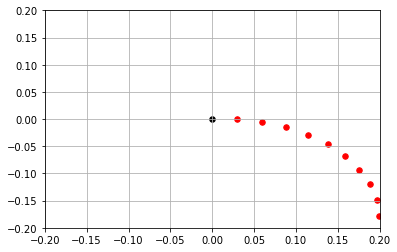

 -- x_train -- 
[[ 2.99670761e-02  6.77500684e-08 -1.81427859e+00]
 [ 5.95402462e-02 -4.84278892e-03 -1.97659859e+00]
 [ 8.79420322e-02 -1.44012514e-02 -2.13891859e+00]
 [ 1.14425752e-01 -2.84240278e-02 -2.30123859e+00]
 [ 1.38295148e-01 -4.65424597e-02 -2.46355859e+00]
 [ 1.58922695e-01 -6.82802138e-02 -2.62587859e+00]
 [ 1.75766095e-01 -9.30658048e-02 -2.78819859e+00]
 [ 1.88382535e-01 -1.20247620e-01 -2.95051859e+00]
 [ 1.96440330e-01 -1.49111050e-01 -3.11283859e+00]
 [ 1.99727640e-01 -1.78897276e-01 -3.27515859e+00]]


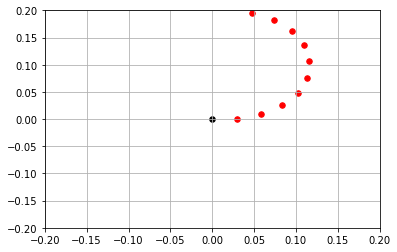

 -- x_train -- 
[[ 2.98901490e-02 -1.08527189e-07 -1.12587770e+00]
 [ 5.84751110e-02  8.73607817e-03 -8.29267696e-01]
 [ 8.32584360e-02  2.54455907e-02 -5.32657696e-01]
 [ 1.02075688e-01  4.86691141e-02 -2.36047696e-01]
 [ 1.13283474e-01  7.63784365e-02  6.05623041e-02]
 [ 1.15902968e-01  1.06153581e-01  3.57172304e-01]
 [ 1.09705400e-01  1.35394155e-01  6.53782304e-01]
 [ 9.52320289e-02  1.61546450e-01  9.50392304e-01]
 [ 7.37468787e-02  1.82326473e-01  1.24700230e+00]
 [ 4.71263412e-02  1.95919412e-01  1.54361230e+00]]


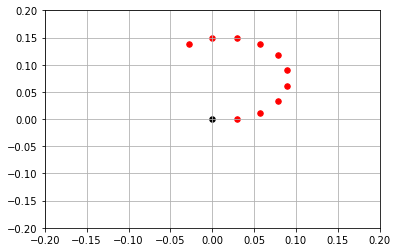

 -- x_train -- 
[[ 2.98066058e-02 -5.14219436e-08 -9.80214602e-01]
 [ 5.73326792e-02  1.14345031e-02 -5.86494602e-01]
 [ 7.83660901e-02  3.25539106e-02 -1.92774602e-01]
 [ 8.96882373e-02  6.01264102e-02  2.00945398e-01]
 [ 8.95665686e-02  8.99327677e-02  5.94665398e-01]
 [ 7.80197022e-02  1.17411917e-01  9.88385398e-01]
 [ 5.68145775e-02  1.38358908e-01  1.38210540e+00]
 [ 2.91960719e-02  1.49568364e-01  1.77582540e+00]
 [-6.09540179e-04  1.49324977e-01  2.16954540e+00]
 [-2.80413065e-02  1.37665991e-01  2.56326540e+00]]


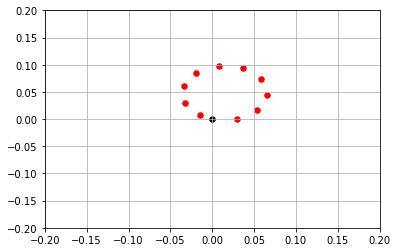

 -- x_train -- 
[[ 2.95572087e-02 -7.08432076e-08 -6.76043930e-01]
 [ 5.40101283e-02  1.66036427e-02 -7.95439300e-02]
 [ 6.49130533e-02  4.40764441e-02  5.16956070e-01]
 [ 5.85002616e-02  7.29296014e-02  1.11345607e+00]
 [ 3.69866443e-02  9.31976268e-02  1.70995607e+00]
 [ 7.80271205e-03  9.78802202e-02  2.30645607e+00]
 [-1.89718022e-02  8.53600776e-02  2.90295607e+00]
 [-3.40893455e-02  5.99614857e-02  3.49945607e+00]
 [-3.23285242e-02  3.04567727e-02  4.09595607e+00]
 [-1.42975019e-02  7.03646477e-03  4.69245607e+00]]


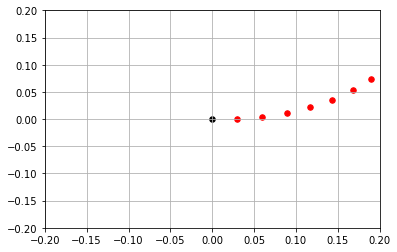

 -- x_train -- 
[[ 2.99812641e-02 -6.89874190e-08 -1.38713403e+00]
 [ 5.97380843e-02  3.66160329e-03 -1.26469403e+00]
 [ 8.88249168e-02  1.09301912e-02 -1.14225403e+00]
 [ 1.16806249e-01  2.16968634e-02 -1.01981403e+00]
 [ 1.43263122e-01  3.58004124e-02 -8.97374026e-01]
 [ 1.67799400e-01  5.30296679e-02 -7.74934026e-01]
 [ 1.90047706e-01  7.31266592e-02 -6.52494026e-01]
 [ 2.09674921e-01  9.57904774e-02 -5.30054026e-01]
 [ 2.26387168e-01  1.20681781e-01 -4.07614026e-01]
 [ 2.39934218e-01  1.47427876e-01 -2.85174026e-01]]


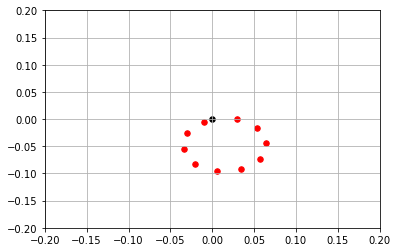

 -- x_train -- 
[[ 2.95437929e-02  8.98715892e-09 -2.47906163e+00]
 [ 5.38350567e-02 -1.68157633e-02 -3.08457163e+00]
 [ 6.42363973e-02 -4.44680293e-02 -3.69008163e+00]
 [ 5.70493459e-02 -7.31243024e-02 -4.29559163e+00]
 [ 3.48294467e-02 -9.25950953e-02 -4.90110163e+00]
 [ 5.47756596e-03 -9.59570583e-02 -5.50661163e+00]
 [-2.05694674e-02 -8.20147574e-02 -6.11212163e+00]
 [-3.40499493e-02 -5.57257425e-02 -6.71763163e+00]
 [-3.01705419e-02 -2.64377604e-02 -7.32314163e+00]
 [-1.03106699e-02 -4.56491918e-03 -7.92865163e+00]]


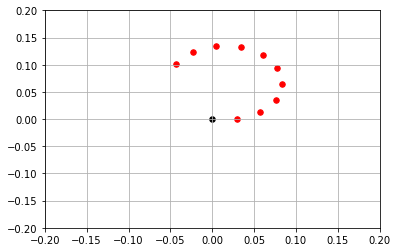

 -- x_train -- 
[[ 2.97596347e-02 -1.13986194e-07 -9.12232497e-01]
 [ 5.66969186e-02  1.26497318e-02 -4.73192497e-01]
 [ 7.57023955e-02  3.55501184e-02 -3.41524966e-02]
 [ 8.31711122e-02  6.43573073e-02  4.04887503e-01]
 [ 7.76864049e-02  9.36071593e-02  8.43927503e-01]
 [ 6.02886111e-02  1.17751571e-01  1.28296750e+00]
 [ 3.42777392e-02  1.32210838e-01  1.72200750e+00]
 [ 4.58752366e-03  1.34242331e-01  2.16104750e+00]
 [-2.31504042e-02  1.23460716e-01  2.60008750e+00]
 [-4.36747224e-02  1.01911047e-01  3.03912750e+00]]


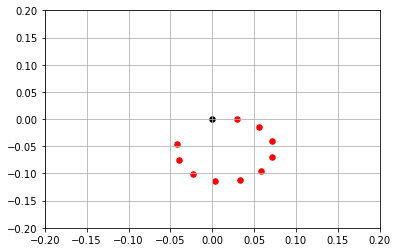

 -- x_train -- 
[[ 2.96706396e-02  6.60477376e-08 -2.34203855e+00]
 [ 5.55050803e-02 -1.45920047e-02 -2.85619855e+00]
 [ 7.08228533e-02 -4.00028821e-02 -3.37035855e+00]
 [ 7.16629705e-02 -6.96616255e-02 -3.88451855e+00]
 [ 5.78081882e-02 -9.58988483e-02 -4.39867855e+00]
 [ 3.28411826e-02 -1.11929927e-01 -4.91283855e+00]
 [ 3.21811471e-03 -1.13609422e-01 -5.42699855e+00]
 [-2.34008542e-02 -1.00503036e-01 -5.94115855e+00]
 [-4.01323860e-02 -7.59999202e-02 -6.45531855e+00]
 [-4.26499120e-02 -4.64362783e-02 -6.96947855e+00]]


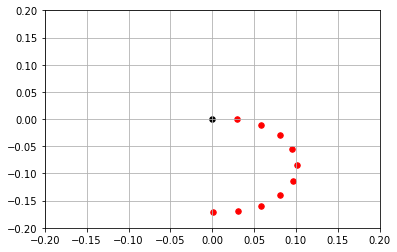

 -- x_train -- 
[[ 2.98490571e-02  2.96714594e-08 -2.09243732e+00]
 [ 5.79113134e-02 -1.01722848e-02 -2.44019732e+00]
 [ 8.08270683e-02 -2.92990823e-02 -2.78795732e+00]
 [ 9.58527766e-02 -5.50904433e-02 -3.13571732e+00]
 [ 1.01189514e-01 -8.44585458e-02 -3.48347732e+00]
 [ 9.61983489e-02 -1.13887349e-01 -3.83123732e+00]
 [ 8.14768399e-02 -1.39853546e-01 -4.17899732e+00]
 [ 5.87874915e-02 -1.59248383e-01 -4.52675732e+00]
 [ 3.08467431e-02 -1.69749849e-01 -4.87451732e+00]
 [ 9.99747760e-04 -1.70100676e-01 -5.22227732e+00]]


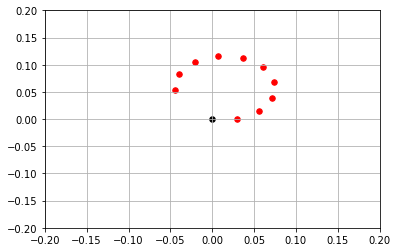

 -- x_train -- 
[[ 2.96832487e-02 -1.38597844e-07 -8.14506658e-01]
 [ 5.56729612e-02  1.43396697e-02 -3.10316658e-01]
 [ 7.15011333e-02  3.94507076e-02  1.93873342e-01]
 [ 7.32286417e-02  6.90836449e-02  6.98063342e-01]
 [ 6.04255652e-02  9.58637959e-02  1.20225334e+00]
 [ 3.62781780e-02  1.13126442e-01  1.70644334e+00]
 [ 6.79598857e-03  1.16575465e-01  2.21063334e+00]
 [-2.06838338e-02  1.05352515e-01  2.71482334e+00]
 [-3.93224445e-02  8.22506218e-02  3.21901334e+00]
 [-4.44812925e-02  5.30191056e-02  3.72320334e+00]]


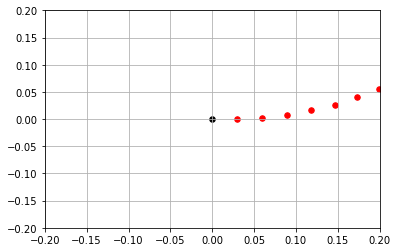

 -- x_train -- 
[[ 2.99898107e-02 -6.87438846e-08 -1.43535903e+00]
 [ 5.98574679e-02  2.70396520e-03 -1.34506903e+00]
 [ 8.93596473e-02  8.09007275e-03 -1.25477903e+00]
 [ 1.18256002e-01  1.61143746e-02 -1.16448903e+00]
 [ 1.46311121e-01  2.67114989e-02 -1.07419903e+00]
 [ 1.73296446e-01  3.97951135e-02 -9.83909035e-01]
 [ 1.98992135e-01  5.52586295e-02 -8.93619035e-01]
 [ 2.23188851e-01  7.29760695e-02 -8.03329035e-01]
 [ 2.45689470e-01  9.28030941e-02 -7.13039035e-01]
 [ 2.66310684e-01  1.14578177e-01 -6.22749035e-01]]


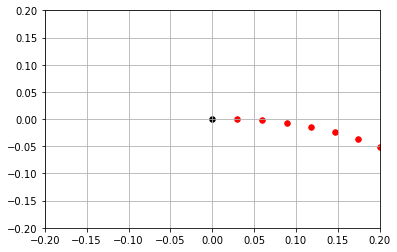

 -- x_train -- 
[[ 2.99913999e-02  8.21511909e-08 -1.69522407e+00]
 [ 5.98796847e-02 -2.48477063e-03 -1.77817407e+00]
 [ 8.94593201e-02 -7.43747060e-03 -1.86112407e+00]
 [ 1.18526894e-01 -1.48239593e-02 -1.94407407e+00]
 [ 1.46882516e-01 -2.45934415e-02 -2.02702407e+00]
 [ 1.74331190e-01 -3.66787349e-02 -2.10997407e+00]
 [ 2.00684160e-01 -5.09967320e-02 -2.19292407e+00]
 [ 2.25760203e-01 -6.74489712e-02 -2.27587407e+00]
 [ 2.49386875e-01 -8.59223145e-02 -2.35882407e+00]
 [ 2.71401703e-01 -1.06289725e-01 -2.44177407e+00]]


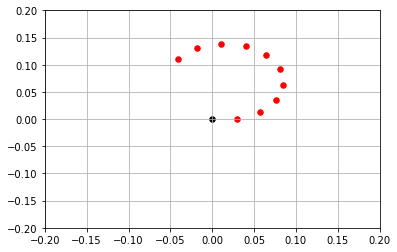

 -- x_train -- 
[[ 2.97721079e-02 -1.09673817e-07 -9.29587643e-01]
 [ 5.68652933e-02  1.23424070e-02 -5.02117643e-01]
 [ 7.64037322e-02  3.48063295e-02 -7.46476430e-02]
 [ 8.48711904e-02  6.33489390e-02  3.52822357e-01]
 [ 8.07438221e-02  9.28335662e-02  7.80292357e-01]
 [ 6.47644091e-02  1.17954011e-01  1.20776236e+00]
 [ 3.98086855e-02  1.34189475e-01  1.63523236e+00]
 [ 1.03678072e-02  1.38618142e-01  2.06270236e+00]
 [-1.82598995e-02  1.30443008e-01  2.49017236e+00]
 [-4.09224508e-02  1.11135311e-01  2.91764236e+00]]


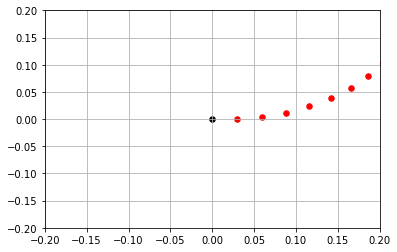

 -- x_train -- 
[[ 2.99773923e-02 -1.41766031e-08 -1.36904585e+00]
 [ 5.96840458e-02  4.01978551e-03 -1.23454585e+00]
 [ 8.85833692e-02  1.19867894e-02 -1.10004585e+00]
 [ 1.16153354e-01  2.37570896e-02 -9.65545854e-01]
 [ 1.41896005e-01  3.91180792e-02 -8.31045854e-01]
 [ 1.65346331e-01  5.77922928e-02 -6.96545854e-01]
 [ 1.86080750e-01  7.94424180e-02 -5.62045854e-01]
 [ 2.03724736e-01  1.03677389e-01 -4.27545854e-01]
 [ 2.17959585e-01  1.30059449e-01 -2.93045854e-01]
 [ 2.28528175e-01  1.58112060e-01 -1.58545854e-01]]


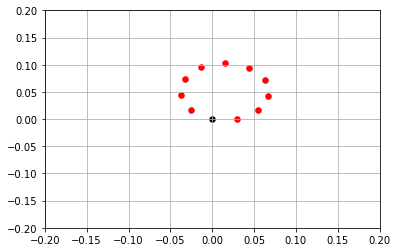

 -- x_train -- 
[[ 2.95967217e-02 -5.94543742e-08 -7.17069318e-01]
 [ 5.45278293e-02  1.59500444e-02 -1.47919318e-01]
 [ 6.69330111e-02  4.28215424e-02  4.21230682e-01]
 [ 6.29011455e-02  7.21423541e-02  9.90380682e-01]
 [ 4.37034043e-02  9.46681763e-02  1.55953068e+00]
 [ 1.53924759e-02  1.03297039e-01  2.12868068e+00]
 [-1.31057338e-02  9.53084232e-02  2.69783068e+00]
 [-3.28062727e-02  7.32209900e-02  3.26698068e+00]
 [-3.74979295e-02  4.39984936e-02  3.83613068e+00]
 [-2.57015128e-02  1.68542403e-02  4.40528068e+00]]


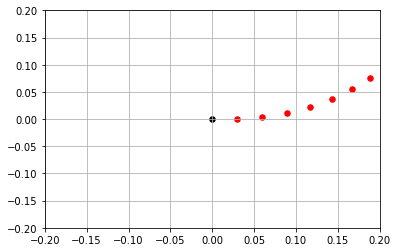

 -- x_train -- 
[[ 2.99800580e-02 -1.30048385e-07 -1.38131199e+00]
 [ 5.97212583e-02  3.77675833e-03 -1.25499199e+00]
 [ 8.87496589e-02  1.12704784e-02 -1.12867199e+00]
 [ 1.16602677e-01  2.23616137e-02 -1.00235199e+00]
 [ 1.42836459e-01  3.68734210e-02 -8.76031989e-01]
 [ 1.67032956e-01  5.45746470e-02 -7.49711989e-01]
 [ 1.88806584e-01  7.51832132e-02 -6.23391989e-01]
 [ 2.07810369e-01  9.83707109e-02 -4.97071989e-01]
 [ 2.23741475e-01  1.23767635e-01 -3.70751989e-01]
 [ 2.36346031e-01  1.50969272e-01 -2.44431989e-01]]


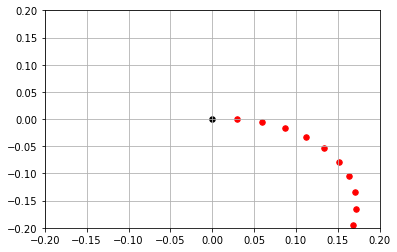

 -- x_train -- 
[[ 2.99545101e-02  3.59686185e-08 -1.85701253e+00]
 [ 5.93653808e-02 -5.68092906e-03 -2.04782253e+00]
 [ 8.71650526e-02 -1.68366867e-02 -2.23863253e+00]
 [ 1.12344449e-01 -3.30623039e-02 -2.42944253e+00]
 [ 1.33989606e-01 -5.37688211e-02 -2.62025253e+00]
 [ 1.51314845e-01 -7.82046306e-02 -2.81106253e+00]
 [ 1.63691291e-01 -1.05482758e-01 -3.00187253e+00]
 [ 1.70669704e-01 -1.34613059e-01 -3.19268253e+00]
 [ 1.71996779e-01 -1.64538158e-01 -3.38349253e+00]
 [ 1.67624347e-01 -1.94171830e-01 -3.57430253e+00]]


In [6]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    plt.xlim([-.2,.2])
    plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])


In [7]:
# loss
def error_squares(z_oplus,z_true, scale=DATA_M_PER_STEP):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p))) / scale
    return error

def error_limit_rotate_vel(predict,limit):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data < limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_limit_trans_vel(predict,limit):
    w = xp.array([1., 0., 0.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data <= limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_diff_v(y0, y1, scale=DATA_M_PER_STEP):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0)) / scale
    return error

def error_diff_w(y0, y1, scale=DATA_RAD_PER_STEP):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0)) / scale
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    # limit v
    e_lim_v = error_limit_trans_vel(y[0,0], DATA_M_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_v = e_lim_v + error_limit_trans_vel(y[0,i], DATA_M_PER_STEP)
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    # limit w
    e_lim_w = error_limit_rotate_vel(y[0,0], DATA_RAD_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_w = e_lim_w + error_limit_rotate_vel(y[0,i] , DATA_RAD_PER_STEP)
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_distance) + '\t'
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_distance) + '\t'
    loss = (5 * e_distance) + (1 * e_diff_v) + (1 * e_diff_w)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    if(disp_loss):
        print(dmesg)
    return loss

In [ ]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y = model(x)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
            y_pad = F.concat((y,pad),axis=2)
            y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
            # loss
            loss = loss_function(y_pad, X[itr][:])
            model.cleargrads()
            loss.backward()
            opt.update()
            # y_grad = chainer.grad( (e,), (y,) )[0]
            # print(y_grad)
            # x_grad = chainer.grad( (e,), (x,) )[0]
            # print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    fig = plt.figure()
    plt.plot(range(len(AvgLoss)),AvgLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(AvgLoss)-1, AvgLoss[-1],str(AvgLoss[-1]),ha='center',va='top' )
    return model, fig

In [ ]:
EPOCH = 100
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
model, fig = train(model,X_train,epoch=EPOCH)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

Epoch: 1 , Average loss: 86.453255
Epoch: 2 , Average loss: 45.165207
Epoch: 3 , Average loss: 38.75094
Epoch: 4 , Average loss: 34.557243
Epoch: 5 , Average loss: 31.326872
Epoch: 6 , Average loss: 29.723188
Epoch: 7 , Average loss: 27.613672
Epoch: 8 , Average loss: 27.255192
Epoch: 9 , Average loss: 26.49938
Epoch: 10 , Average loss: 25.309528
Epoch: 11 , Average loss: 24.94529
Epoch: 12 , Average loss: 24.396702
Epoch: 13 , Average loss: 23.975027
Epoch: 14 , Average loss: 23.641592
Epoch: 15 , Average loss: 22.864855
Epoch: 16 , Average loss: 22.208931
Epoch: 17 , Average loss: 21.75056
Epoch: 18 , Average loss: 21.384953
Epoch: 19 , Average loss: 21.37564
Epoch: 20 , Average loss: 20.50253
Epoch: 21 , Average loss: 20.77202
Epoch: 22 , Average loss: 20.152382
Epoch: 23 , Average loss: 20.02352
Epoch: 24 , Average loss: 19.921278
Epoch: 25 , Average loss: 19.798262
Epoch: 26 , Average loss: 19.44207
Epoch: 27 , Average loss: 19.324495
Epoch: 28 , Average loss: 19.194502
Epoch: 29 

In [ ]:
# log
def gen_filename():
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_M_PER_STEP * 1000))
    fn = 'Cart' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename()
os.mkdir(dirname)
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

In [ ]:
rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
x_test = data.generate_arc_path(DATA_NUM_WAYPOINTS,rand_rad,DATA_M_PER_STEP)
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y = model(x)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
y_pad = F.concat((y,pad),axis=2)
y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
print(xp.rad2deg(y_pad.data[:,:,2]))
# loss
z_true = x_test
z = y_pad[0,0]
print(' --- error --- ')
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
print(' --- trajectory --- ')
print(Z)
print(z_true.shape)
fig = plot_path(Z,z_true,[-.1,.4],[-.4,.4])
print(' --- grad --- ')
loss.backward()
y_grad = chainer.grad( (loss,), (y,) )[0]
print(y_grad)

In [ ]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    x_test = data.generate_arc_path(DATA_NUM_WAYPOINTS,rand_rad,DATA_M_PER_STEP)
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y = model(x)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
    y_pad = F.concat((y,pad),axis=2)
    y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    print(' --- trajectory --- ')
    print(Z)
    print(z_true.shape)
    fig = plot_path(Z,z_true,[-.1,.4],[-.4,.4])
    fig.savefig(dirname + '/test' + str(i) + '.png')